# Predicting-Customer-Churn-using-Feed-Forward-Neural-Networks



**Customer churn** is a financial term that refers to the loss of a client or customer—that is, when a customer ceases to interact with a company or business. Similarly, the churn rate is the rate at which customers or clients are leaving a company within a specific period of time. A churn rate higher than a certain threshold can have both tangible and intangible effects on a company's business success. Ideally, companies like to retain as many customers as they can.

Steps Taken

1. Obtaining and preprocessing a customer churn dataset.
2. Spliting the data into training and testing sets.
3. Implementing a feed-forward neural network using PyTorch.
4. Experimenting with different network architectures, activation functions, and learning rates.
5. Evaluating the model using appropriate metrics, such as accuracy, precision, recall, and F1 score.
6. Preparing a written report discussing the approach, model architecture, training process, and evaluation results in detail.

In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

### 1. Obtain and preprocess a customer churn dataset.

Data source: https://www.kaggle.com/yeanzc/telco-customer-churn-ibm-dataset

In [51]:
# load and preview data

df = pd.read_excel('Telco_customer_churn.xlsx')

df.head()

# #Code to run on Google Colab

# from google.colab import drive
# drive.mount('/content/drive')

# file_path = '/content/drive/MyDrive/Colab Notebooks/Telco_customer_churn.xlsx'

# import pandas as pd
# df = pd.read_excel(file_path)

# df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [52]:
# summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [53]:

print("Shape of dataset:",df.shape)

Shape of dataset: (7043, 33)


In [54]:
# Drop columns which are not required for model building
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'], axis=1, inplace=True)

In [55]:
df['Count'].unique()

array([1])

In [56]:
df['Country'].unique()

array(['United States'], dtype=object)

In [57]:
df['State'].unique()

array(['California'], dtype=object)

In [58]:
df['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

In [59]:
# Dropping univariate columns
df.drop(['CustomerID', 'Count', 'Country', 'State', 'Lat Long'], axis=1, inplace=True)

df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [60]:
df['City'].replace(' ', '_', regex=True, inplace=True)

df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [61]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

In [62]:
# Convert column names too
df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Value'],
      dtype='object')

In [63]:
# Columns type
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [64]:
df['Phone_Service'].unique()

array(['Yes', 'No'], dtype=object)

In [65]:
df['Total_Charges'].unique()

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

In [66]:
# See how many occurrences
len(df.loc[df['Total_Charges']==' '])

11

In [67]:
# Let's look them
df.loc[df['Total_Charges']==' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [68]:
# Set the 'Total_Charges' to 0 in these 11 cases, ' ' to zero.

df.loc[(df['Total_Charges']==' '), 'Total_Charges'] = 0

In [69]:
# Check
len(df.loc[df['Total_Charges']==' '])

0

In [70]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

In [71]:
# Now, let's do the same for All DataFrame.

df.replace(' ', '_', regex=True, inplace=True)

df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


### 2. Split the data into training and testing sets.

In [72]:
X = df.drop('Churn_Value', axis=1).copy()

y = df['Churn_Value'].copy()

In [73]:
#set df view to show all columns
pd.set_option('display.max_columns', None)


In [74]:
X.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges'],
      dtype='object')

In [75]:
# shape
X.shape

(7043, 23)

In [76]:
# number of unique values in each object column
X.select_dtypes('object').nunique()


City                 1129
Gender                  2
Senior_Citizen          2
Partner                 2
Dependents              2
Phone_Service           2
Multiple_Lines          3
Internet_Service        3
Online_Security         3
Online_Backup           3
Device_Protection       3
Tech_Support            3
Streaming_TV            3
Streaming_Movies        3
Contract                3
Paperless_Billing       2
Payment_Method          4
dtype: int64

In [77]:
#drop City
X.drop('City', axis=1, inplace=True)

In [78]:
# change Zip_Code to object
X['Zip_Code'] = X['Zip_Code'].astype('object')

#unique values in Zip_Code
X['Zip_Code'].nunique()

# drop ZIP code
X.drop('Zip_Code', axis=1, inplace=True)

In [79]:
# Let's do it for all qualitative columns

X_encoded = pd.get_dummies(X, columns=[
                                       'Gender',
                                       'Senior_Citizen',
                                       'Partner',
                                       'Dependents',
                                       'Phone_Service',
                                       'Multiple_Lines',
                                       'Internet_Service',
                                       'Online_Security',
                                       'Online_Backup',
                                       'Device_Protection',
                                       'Tech_Support',
                                       'Streaming_TV',
                                       'Streaming_Movies',
                                       'Contract',
                                       'Paperless_Billing',
                                       'Payment_Method'])
X_encoded.head()

,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,Gender_Female,Gender_Male,Senior_Citizen_No,Senior_Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone_Service_No,Phone_Service_Yes,Multiple_Lines_No,Multiple_Lines_No_phone_service,Multiple_Lines_Yes,Internet_Service_DSL,Internet_Service_Fiber_optic,Internet_Service_No,Online_Security_No,Online_Security_No_internet_service,Online_Security_Yes,Online_Backup_No,Online_Backup_No_internet_service,Online_Backup_Yes,Device_Protection_No,Device_Protection_No_internet_service,Device_Protection_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,33.964131,-118.272783,2,53.85,108.15,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
1,34.059281,-118.307420,2,70.70,151.65,True,False,True,False,True,False,False,True,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
2,34.048013,-118.293953,8,99.65,820.50,True,False,True,False,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False
3,34.062125,-118.315709,28,104.80,3046.05,True,False,True,False,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False
4,34.039224,-118.266293,49,103.70,5036.30,False,True,True,False,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,False,True,True,False,False,False


In [80]:
#columnn types
X_encoded.dtypes

Latitude                                    float64
Longitude                                   float64
Tenure_Months                                 int64
Monthly_Charges                             float64
Total_Charges                               float64
Gender_Female                                  bool
Gender_Male                                    bool
Senior_Citizen_No                              bool
Senior_Citizen_Yes                             bool
Partner_No                                     bool
Partner_Yes                                    bool
Dependents_No                                  bool
Dependents_Yes                                 bool
Phone_Service_No                               bool
Phone_Service_Yes                              bool
Multiple_Lines_No                              bool
Multiple_Lines_No_phone_service                bool
Multiple_Lines_Yes                             bool
Internet_Service_DSL                           bool
Internet_Ser

In [81]:
#Convert all columns to float
X_encoded = X_encoded.astype(float)

#head
X_encoded.head()



,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,Gender_Female,Gender_Male,Senior_Citizen_No,Senior_Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone_Service_No,Phone_Service_Yes,Multiple_Lines_No,Multiple_Lines_No_phone_service,Multiple_Lines_Yes,Internet_Service_DSL,Internet_Service_Fiber_optic,Internet_Service_No,Online_Security_No,Online_Security_No_internet_service,Online_Security_Yes,Online_Backup_No,Online_Backup_No_internet_service,Online_Backup_Yes,Device_Protection_No,Device_Protection_No_internet_service,Device_Protection_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,33.964131,-118.272783,2.0,53.85,108.15,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,34.059281,-118.307420,2.0,70.70,151.65,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,34.048013,-118.293953,8.0,99.65,820.50,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,34.062125,-118.315709,28.0,104.80,3046.05,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,34.039224,-118.266293,49.0,103.70,5036.30,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [82]:
#x_encoded shape
X_encoded.shape

(7043, 48)

In [83]:
# y shape
y.shape

(7043,)

In [84]:
# Lets see how imbalance is this dataset looking for y=1:
sum(y) / len(y)

0.2653698707936959

In [85]:
# Split the trains and tests
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [86]:
# target class distribution
print('y_train class distribution')
print(y_train.value_counts(normalize=True))

y_train class distribution
Churn_Value
0    0.73457
1    0.26543
Name: proportion, dtype: float64


### 3. Implementing a feed-forward neural network using PyTorch.

In [96]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#creating a baseline model

class BinaryClassifier(pl.LightningModule):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_pred = y_hat > 0.5
        accuracy = (y_pred == y).float().mean()
        self.log('test_accuracy', accuracy)
        return y_pred, y

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return test_loader

    def test_dataloader(self):
        return test_loader

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train.values.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32)).unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32)).unsqueeze(1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
num_workers = os.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 100
model = BinaryClassifier(input_size, hidden_size1, hidden_size2)

# Train the model
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type   | Params
----------------------------------------
0 | layer1       | Linear | 4.9 K 
1 | layer2       | Linear | 10.1 K
2 | output_layer | Linear | 101   
----------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 83/83 [00:05<00:00, 15.33it/s, v_num=8, train_loss_step=0.356, val_loss_step=0.435, val_loss_epoch=0.415, train_loss_epoch=0.447]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 83/83 [00:05<00:00, 15.30it/s, v_num=8, train_loss_step=0.356, val_loss_step=0.435, val_loss_epoch=0.415, train_loss_epoch=0.447]


In [97]:
#save the model
torch.save(model.state_dict(), 'model1.pth')


Accuracy: 0.8001135718341851


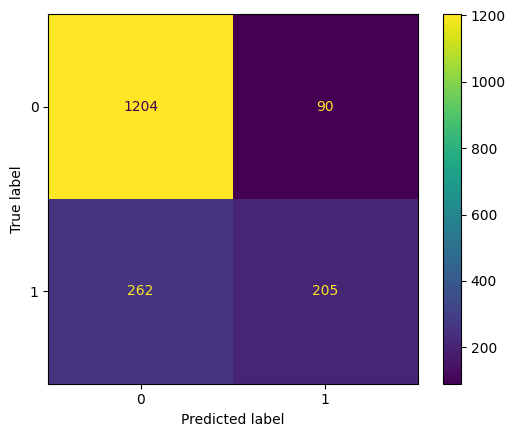

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      1294
         1.0       0.69      0.44      0.54       467

    accuracy                           0.80      1761
   macro avg       0.76      0.68      0.71      1761
weighted avg       0.79      0.80      0.78      1761



In [99]:
#load the model and evaluate

def load_eval_model(model_path, test_loader):
    model1 = BinaryClassifier(input_size, hidden_size1, hidden_size2)
    model1.load_state_dict(torch.load(model_path))
    model1.eval()

    # Test the model
    y_pred = []
    y_true = []
    for x, y in test_loader:
        y_pred_batch = model1(x)
        y_pred.extend(y_pred_batch)
        y_true.extend(y)

    y_pred = torch.cat(y_pred).detach().numpy()
    y_true = torch.cat(y_true).detach().numpy()

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred > 0.5)
    print('Accuracy:', accuracy)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred > 0.5)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred > 0.5))


load_eval_model('model1.pth', test_loader)



# Baseline Model (Feed Forward Neural Network) Evaluation:

Accuracy: 80%
Recall: 44%

We want to go with recall as our evaluation metric because we want to minimize false negatives. We want to minimize the number of customers that we predict will not churn but actually do churn. It is because the cost of losing a customer is higher than the cost of retaining a customer.

### 4. Experimenting with different network architectures, activation functions, and learning rates.

In [111]:
class BinaryClassifierArc(pl.LightningModule):
    def __init__(self, input_size, hidden_sizes, activation_fn, learning_rate):
        super(BinaryClassifierArc, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], 1)
        self.activation_fn = activation_fn
        self.learning_rate = learning_rate

    def forward(self, x):
        for layer in self.layers:
            x = self.activation_fn(layer(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_pred = y_hat > 0.5
        accuracy = (y_pred == y).float().mean()
        self.log('test_accuracy', accuracy)
        return y_pred, y

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return test_loader

    def test_dataloader(self):
        return test_loader

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train.values.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32)).unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32)).unsqueeze(1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
num_workers = os.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Define different architectures and hyperparameters
architectures = [
    {'hidden_sizes': [100, 100], 'activation_fn': nn.ReLU(), 'learning_rate': 0.01},
    {'hidden_sizes': [200, 100], 'activation_fn': nn.Tanh(), 'learning_rate': 0.001},
    {'hidden_sizes': [100, 100, 50], 'activation_fn': nn.LeakyReLU(), 'learning_rate': 0.005},
]

# Train and evaluate models with different architectures
i=1
for arch in architectures:
    print(f"Training model with architecture: {arch}")
    model = BinaryClassifierArc(input_size, arch['hidden_sizes'], arch['activation_fn'], arch['learning_rate'])
    trainer = pl.Trainer(max_epochs=20)
    trainer.fit(model)
    trainer.test(model)

    #save the model
    torch.save(model.state_dict(), f'model_arch_{i}.pth')
    i=i+1

    


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | layers        | ModuleList | 15.0 K
1 | output_layer  | Linear     | 101   
2 | activation_fn | ReLU       | 0     
---------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated model params size (MB)


Training model with architecture: {'hidden_sizes': [100, 100], 'activation_fn': ReLU(), 'learning_rate': 0.01}
Epoch 1:   0%|          | 0/83 [00:00<?, ?it/s, v_num=18, train_loss_step=2.780, val_loss_step=4.180, val_loss_epoch=4.600, train_loss_epoch=19.80]         

ERROR: Unexpected segmentation fault encountered in worker.
 

Epoch 19: 100%|██████████| 83/83 [00:05<00:00, 16.56it/s, v_num=18, train_loss_step=0.549, val_loss_step=0.454, val_loss_epoch=0.423, train_loss_epoch=0.428]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 169.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7955706715583801     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | layers        | ModuleList | 29.9 K
1 | output_layer  | Linear     | 101   
2 | activation_fn | Tanh       | 0     
---------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Training model with architecture: {'hidden_sizes': [200, 100], 'activation_fn': Tanh(), 'learning_rate': 0.001}
Epoch 2:   0%|          | 0/83 [00:00<?, ?it/s, v_num=19, train_loss_step=0.397, val_loss_step=0.587, val_loss_epoch=0.492, train_loss_epoch=0.472]         

ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 

Epoch 19: 100%|██████████| 83/83 [00:04<00:00, 16.66it/s, v_num=19, train_loss_step=0.541, val_loss_step=0.467, val_loss_epoch=0.446, train_loss_epoch=0.455]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 218.13it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7853492498397827     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | layers        | ModuleList | 20.1 K
1 | output_layer  | Linear     | 51    
2 | activation_fn | LeakyReLU  | 0     
---------------------------------------------
20.1 K    Trainable params
0         Non-trainable params
20.1 K    Total params
0.080     Total estimated model params size (MB)


Training model with architecture: {'hidden_sizes': [100, 100, 50], 'activation_fn': LeakyReLU(negative_slope=0.01), 'learning_rate': 0.005}
Epoch 3: 100%|██████████| 83/83 [00:02<00:00, 30.59it/s, v_num=20, train_loss_step=0.302, val_loss_step=0.479, val_loss_epoch=0.437, train_loss_epoch=0.460]

ERROR: Unexpected segmentation fault encountered in worker.
 

Epoch 12:   0%|          | 0/83 [00:00<?, ?it/s, v_num=20, train_loss_step=0.494, val_loss_step=0.510, val_loss_epoch=0.499, train_loss_epoch=0.431]         

ERROR: Unexpected segmentation fault encountered in worker.
 

Epoch 19: 100%|██████████| 83/83 [00:05<00:00, 16.59it/s, v_num=20, train_loss_step=0.273, val_loss_step=0.438, val_loss_epoch=0.407, train_loss_epoch=0.418]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 478.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8080636262893677     │
└───────────────────────────┴───────────────────────────┘

### 5. Evaluating the model using appropriate metrics, such as accuracy, precision, recall, and F1 score.

Evaluating Model With Architecture: {'hidden_sizes': [100, 100], 'activation_fn': ReLU(), 'learning_rate': 0.01}
Accuracy: 0.7955706984667802


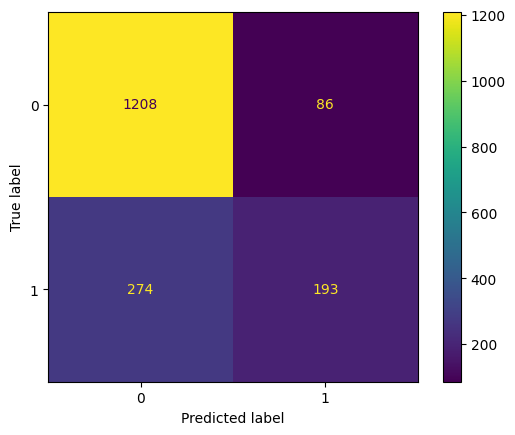

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      1294
         1.0       0.69      0.41      0.52       467

    accuracy                           0.80      1761
   macro avg       0.75      0.67      0.69      1761
weighted avg       0.78      0.80      0.78      1761

Evaluating Model With Architecture: {'hidden_sizes': [200, 100], 'activation_fn': Tanh(), 'learning_rate': 0.001}
Accuracy: 0.7853492333901193


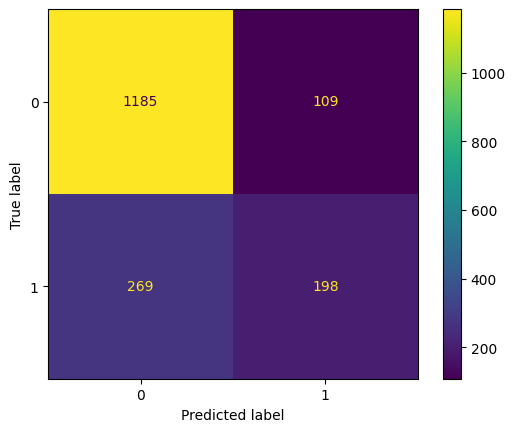

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      1294
         1.0       0.64      0.42      0.51       467

    accuracy                           0.79      1761
   macro avg       0.73      0.67      0.69      1761
weighted avg       0.77      0.79      0.77      1761

Evaluating Model With Architecture: {'hidden_sizes': [100, 100, 50], 'activation_fn': LeakyReLU(negative_slope=0.01), 'learning_rate': 0.005}
Accuracy: 0.8080636002271436


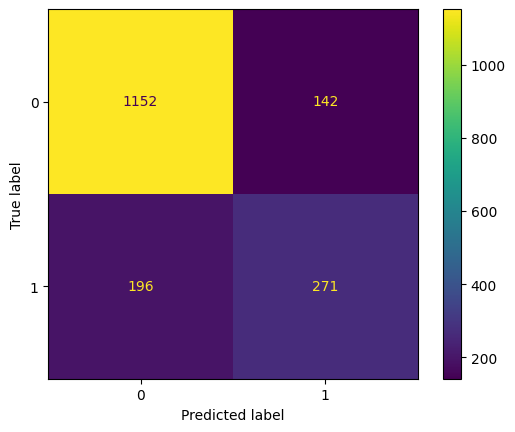

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1294
         1.0       0.66      0.58      0.62       467

    accuracy                           0.81      1761
   macro avg       0.76      0.74      0.74      1761
weighted avg       0.80      0.81      0.80      1761



In [112]:
model_path = ['model_arch_1.pth', 'model_arch_2.pth', 'model_arch_3.pth']
i=0

for arch in architectures:
    print(f"Evaluating Model With Architecture: {arch}")
    model = BinaryClassifierArc(input_size, arch['hidden_sizes'], arch['activation_fn'], arch['learning_rate'])
    model.load_state_dict(torch.load(model_path[i]))
    model.eval()
    i=i+1

    # Test the model
    y_pred = []
    y_true = []
    for x, y in test_loader:
        y_pred_batch = model(x)
        y_pred.extend(y_pred_batch)
        y_true.extend(y)

    y_pred = torch.cat(y_pred).detach().numpy()
    y_true = torch.cat(y_true).detach().numpy()

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred > 0.5)
    print('Accuracy:', accuracy)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred > 0.5)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred > 0.5))

#### Evaluation of the all three architectures:

Base Model:
- hidden_sizes: [100, 100],
- activation_fn: nn.ReLU(),
- learning_rate: 0.01

- Accuracy: 80%
- Recall: 44%

Architecture 1:
- hidden_sizes: [100, 100], 
- activation_fn: nn.ReLU(), 
- learning_rate: 0.01

- Accuracy: 79.55%
- Recall: 41%

Architecture 2:
- hidden_sizes: [200, 100], 
- activation_fn: nn.Tanh(), 
- learning_rate: 0.001

- Accuracy: 78.53%
- Recall: 42%

Architecture 3:
- hidden_sizes: [100, 100, 50], 
- activation_fn: nn.LeakyReLU(), 
- learning_rate: 0.005

- Accuracy: 80.80%
- Recall: 58%



### 6. Preparing a written report discussing the approach, model architecture, training process, and evaluation results in detail.

Access report from the Github repository: [Predicting Customer Churn using Feed-Forward Neural Networks](https://github.com/krishangupta33/Predicting-Customer-Churn-using-Feed-Forward-Neural-Networks)

